In [39]:
import pickle
from data_process import Get_Offense
from class_offfense import Offense

In [40]:
def get_data():
    with open('data/final_data.pkl', 'rb') as file:
        loaded_data = pickle.load(file)
    list_offense =[]
    for o in loaded_data:
        list_offense.append(Offense(o))

    return(list_offense)

In [42]:
list_offense = get_data()
len(list_offense)

67820

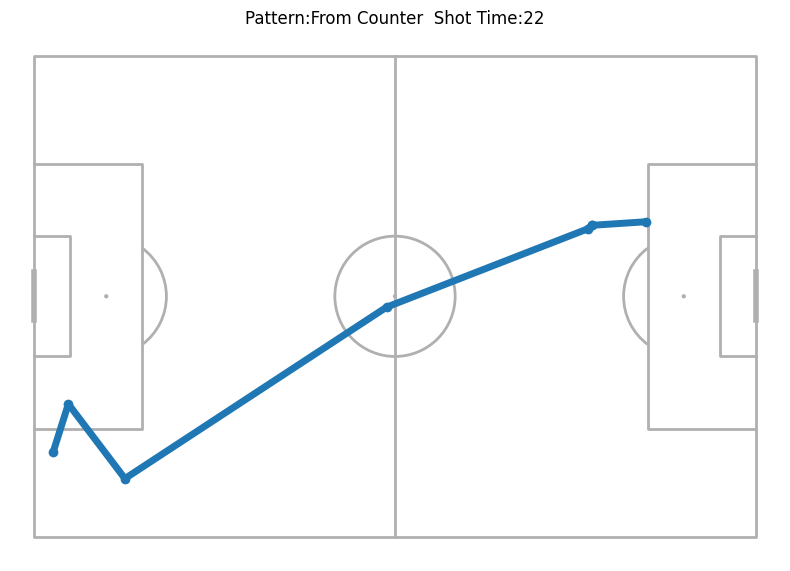

In [43]:
list_offense[3].plot_offense()